In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
def fitting(df):
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(df)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return 

In [3]:
pdloc1 = pd.read_csv('./loc1.csv')

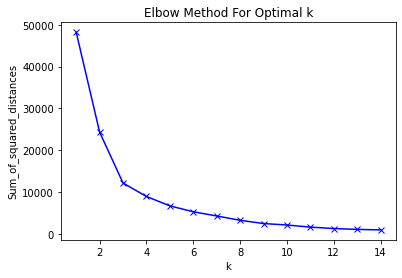

In [4]:
fitting(pdloc1)

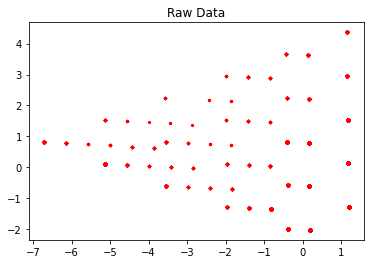

step: 1	likelihood:-40348.80254894821
step: 2	likelihood:-23153.607249172153
step: 3	likelihood:-21415.80647358968
step: 4	likelihood:-19531.68460458865
step: 5	likelihood:-17035.140890903345


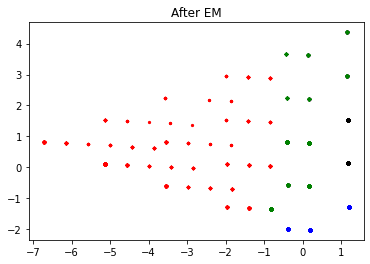

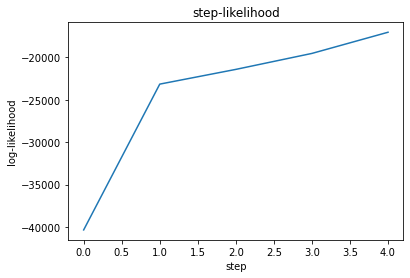

result:
k: [0.2341835762620904, 0.21476265227749888, 0.28398912019466327, 0.2670646512657474]
mu: [array([-2.5222891 ,  0.03816276]), array([0.2413842 , 0.95168152]), array([1.09196303, 0.6626354 ]), array([ 0.85596284, -1.50345241])]
sigma: [array([[ 5.37578313, -0.41984549],
       [-0.41984549,  1.04481985]]), array([[0.52523861, 0.70448755],
       [0.70448755, 3.19997502]]), array([[0.07350965, 0.04595369],
       [0.04595369, 0.5963514 ]]), array([[0.26579042, 0.16984713],
       [0.16984713, 0.11770293]])]


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math


def get_pdf(sample, mu, sigma):
    res = stats.multivariate_normal(mu, sigma).pdf(sample)
    return res


def get_log_likelihood(data, k, mu, sigma, gama):
    res = 0.0
    for i in range(len(data)):
        cur = 0.0
        for j in range(len(k)):
            cur += gama[j][i] * get_pdf(data[i], mu[j], sigma[j])
        res += math.log(cur)
    return res


def em(data, k, mu, sigma, steps=5):
    num_gau = len(k)  # 高斯分布个数
    num_data = data.shape[0]  # 数据个数
    gama = np.zeros((num_gau, num_data))  # gama[j][i]表示第i个样本点来自第j个高斯模型的概率
    likelihood_record = []  # 记录每一次迭代的log-likelihood值
    for step in range(steps):
        # 计算gama矩阵
        for i in range(num_gau):
            for j in range(num_data):
                gama[i][j] = k[i] * get_pdf(data[j], mu[i], sigma[i]) / \
                             sum([k[t] * get_pdf(data[j], mu[t], sigma[t]) for t in range(num_gau)])
        cur_likelihood = get_log_likelihood(data, k, mu, sigma, gama)  # 计算当前log-likelihood
        likelihood_record.append(cur_likelihood)
        # 更新mu
        for i in range(num_gau):
            mu[i] = np.dot(gama[i], data) / np.sum(gama[i])
        # 更新sigma
        for i in range(num_gau):
            cov = [np.dot((data[t] - mu[i]).reshape(-1, 1), (data[t] - mu[i]).reshape(1, -1)) for t in range(num_data)]
            cov_sum = np.zeros((2, 2))
            for j in range(num_data):
                cov_sum += gama[i][j] * cov[j]
            sigma[i] = cov_sum / np.sum(gama[i])
        # 更新k
        for i in range(num_gau):
            k[i] = np.sum(gama[i]) / num_data
        print('step: {}\tlikelihood:{}'.format(step + 1, cur_likelihood))
    return k, mu, sigma, gama, likelihood_record


def main():
    csv_data = pd.read_csv('loc1.csv')
    csv_data = np.array(csv_data)
    # 原始数据散点图
    plt.scatter(csv_data[:, 0], csv_data[:, 1], s=5, c='r')
    plt.title('Raw Data')
    plt.show()
    # GMM参数初始值
    k_init = [0.25, 0.25, 0.25, 0.25]
    mu_init = [[-0.5, -0.5],
               [-0.4, 0.4],
               [0.1, 0.1],
               [1.2, -1.2]]
    sigma_init = [[[1, 0.5], [0.5, 1]],
                  [[0.5, 0], [0, 0.5]],
                  [[0.3, 0], [0, 0.3]],
                  [[0.5, -0.1], [-0.1, 0.5]]]
    k_res, mu_res, sigma_res, gama, likelihood_record = em(csv_data, k_init, mu_init, sigma_init, steps=5)  # EM算法
    # 根据EM算法的结果画分类图
    classify = gama.argmax(axis=0)  # 计算每个样本点所属的单高斯模型
    four_gau = [[], [], [], []]  # 把数据集分成四份，每份属于一个单高斯模型
    for i in range(len(classify)):
        four_gau[classify[i]].append(csv_data[i])
    # 转成numpy，方便画散点图
    four_gau = np.array(four_gau)
    for i in range(len(four_gau)):
        four_gau[i] = np.array(four_gau[i])
    colors = ['r', 'g', 'k', 'b']
    for i in range(len(k_res)):
        plt.scatter(four_gau[i][:, 0], four_gau[i][:, 1], s=5, c=colors[i])
    plt.title('After EM')
    plt.show()
    # 画likelihood的变化曲线图
    plt.plot([n for n in range(len(likelihood_record))], likelihood_record)
    plt.title('step-likelihood')
    plt.xlabel('step')
    plt.ylabel('log-likelihood')
    plt.show()
    print('result:\nk: {}\nmu: {}\nsigma: {}'.format(k_res, mu_res, sigma_res))


if __name__ == '__main__':
    main()